Computer Vision : Assignment - 2

Krishna Praneet Mulukutla

2020113010

Part 1: SIFT-BoVW-SVM

In [182]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import cv2 as cv
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

import wandb

In [183]:
# random seed
np.random.seed(42)
torch.manual_seed(42)

Number of train samples :  60000
Number of train samples :  10000


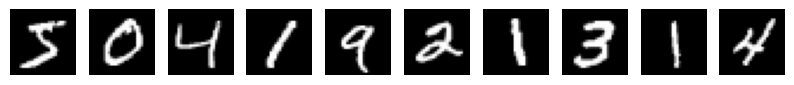

In [184]:
'''Load the MNIST dataset'''
mnist_train = datasets.MNIST(root='./datasets', train=True, download=True, transform=None)
mnist_test = datasets.MNIST(root='./datasets', train=False, download=True, transform=None)
print("Number of train samples : " , len(mnist_train))
print("Number of train samples : " , len(mnist_test))

# display the first 10 images
fig, axs = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    axs[i].imshow(mnist_train[i][0], cmap='gray')
    axs[i].axis('off')
plt.show()

In [185]:
'''SIFT feature extraction for the train set'''
# # detect and compute SIFT features for all train images
# key_point_list = []         # list of key points for each image
# descriptor_list = []        # list of descriptors for each image
# train_features = []         # list of all descriptors
# train_labels = []           # list of labels for each image (one label per image)

# # classify test images
# key_point_list_test = []         # list of key points for each image
# descriptor_list_test = []        # list of descriptors for each image
# test_features = []               # list of all descriptors
# test_labels = []                 # list of labels for each image (one label per image)

def extract_sift_features(nfeatures=0, sigma=1.6):
    sift = cv.SIFT_create(nfeatures=nfeatures, sigma=sigma)

    global key_point_list, descriptor_list, train_features, train_labels
    global key_point_list_test, descriptor_list_test, test_features, test_labels

    key_point_list = []         # list of key points for each image
    descriptor_list = []        # list of descriptors for each image
    train_features = []         # list of all descriptors
    train_labels = []           # list of labels for each image (one label per image)

    key_point_list_test = []         # list of key points for each image
    descriptor_list_test = []        # list of descriptors for each image
    test_features = []               # list of all descriptors
    test_labels = []                 # list of labels for each image (one label per image)


    for i in range(len(mnist_train)):
        img = np.array(mnist_train[i][0])
        kp, des = sift.detectAndCompute(img, None)
        if des is not None:
            key_point_list.append(kp)
            descriptor_list.append(des)
            train_labels.append(mnist_train[i][1])
            train_features.extend(des)
        else:
            key_point_list.append([])
            descriptor_list.append([])
            train_labels.append(mnist_train[i][1])
    train_features = np.array(train_features)
    train_labels = np.array(train_labels)

    print("Number of elements in key_point_list : ", len(key_point_list))
    print("Number of elements in descriptor_list : ", len(descriptor_list))
    print("Number of train features : ", train_features.shape)
    print("Number of train labels : ", train_labels.shape)
    print()


    '''SIFT feature extraction for the test set'''

    for i in range(len(mnist_test)):
        img = np.array(mnist_test[i][0])
        kp, des = sift.detectAndCompute(img, None)
        if des is not None:
            key_point_list_test.append(kp)
            descriptor_list_test.append(des)
            test_labels.append(mnist_test[i][1])
            test_features.extend(des)
        else:
            key_point_list_test.append([])
            descriptor_list_test.append([])
            test_labels.append(mnist_test[i][1])
    test_features = np.array(test_features)
    test_labels = np.array(test_labels)

    print("Number of elements in key_point_list : ", len(key_point_list_test))
    print("Number of elements in descriptor_list : ", len(descriptor_list_test))
    print("Number of test features : ", test_features.shape)
    print("Number of test labels : ", test_labels.shape)
    print()

In [186]:
def cluster_features(k, train_features):
    # use k means to cluster the features
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=4)
    kmeans.fit(train_features)
    print("Number of cluster centers : ", kmeans.cluster_centers_.shape[0])
    print("Dimesion of cluster centers : ", kmeans.cluster_centers_.shape[1])
    print()
    return kmeans

def make_histograms(descriptor_list, kmeans, k):
    # make k sized histogram for each image
    histograms = []
    for i in range(len(descriptor_list)):
        if len(descriptor_list[i]) == 0:
            histograms.append(np.zeros(k))
        else:
            labels = kmeans.predict(descriptor_list[i])
            hist, _ = np.histogram(labels, bins=k, range=(0, k))
            histograms.append(hist)
    histograms = np.array(histograms)
    print("Shape of train histograms : ", histograms.shape)
    print()
    return histograms

def train_SVM(train_histograms, train_labels, c=1.0):
    # train a linear SVM for 10-way classification using the histograms
    svm = LinearSVC(random_state=42, max_iter=10000)
    svm.fit(train_histograms, train_labels)
    return svm

def test_SVM(svm, histograms, labels, testOrTrain='Test'):
    acc = accuracy_score(labels, svm.predict(histograms))
    print(testOrTrain, "Accuracy : ", acc)
    print('-------------------------------------')
    return acc

In [174]:
'''Training and testing a linear SVM using histogram made using SIFT features'''

k_vals = [2, 4, 10, 50, 100, 500]
accuracies = np.zeros((len(k_vals), 2))

extract_sift_features()

for k in k_vals:
    print("k = ", k)
    
    kmeans = cluster_features(k, train_features)
    train_histograms = make_histograms(descriptor_list, kmeans, k)
    svm = train_SVM(train_histograms, train_labels)
    accuracies[k_vals.index(k), 0] = test_SVM(svm, train_histograms, train_labels, 'Train')

    # test the SVM on the test set
    test_histograms = make_histograms(descriptor_list_test, kmeans, k)
    accuracies[k_vals.index(k), 1] = test_SVM(svm, test_histograms, test_labels, 'Test')

plt.plot(k_vals, accuracies[:, 0], label='Train')
plt.plot(k_vals, accuracies[:, 1], label='Test')
plt.xlabel('Number of clusters')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of clusters')
plt.legend()
plt.show()

UnboundLocalError: local variable 'key_point_list' referenced before assignment

As we can see here, for the cluster numbers [2,4,10,50,100,500], we see an increase in the accuracy of the model as the number of clusters increases. Moreover, we also see that the accuracy seems to reach a saturation point. That is, the increase in the accuracy is not as significant as the number of clusters increases for large values of clusters.

In [187]:
part1_Hyp = []  # each element is a list containing [nfeatures, sigma, c]
part1_Hyp.append([0, 1.6, 1.0])
part1_Hyp.append([0, 1.6, 0.1])
part1_Hyp.append([0, 1.6, 10.0])
part1_Hyp.append([0, 0.8, 1.0])
part1_Hyp.append([0, 3.2, 1.0])
part1_Hyp.append([100, 1.6, 1.0])

nfeatures =  0  sigma =  1.6  c =  1.0
Number of elements in key_point_list :  60000
Number of elements in descriptor_list :  60000
Number of train features :  (469496, 128)
Number of train labels :  (60000,)

Number of elements in key_point_list :  10000
Number of elements in descriptor_list :  10000
Number of test features :  (78515, 128)
Number of test labels :  (10000,)

Number of cluster centers :  100
Dimesion of cluster centers :  128

Shape of train histograms :  (60000, 100)

Train Accuracy :  0.7304333333333334
-------------------------------------
Shape of train histograms :  (10000, 100)

Test Accuracy :  0.7299
-------------------------------------
nfeatures =  0  sigma =  1.6  c =  0.1
Number of elements in key_point_list :  60000
Number of elements in descriptor_list :  60000
Number of train features :  (469496, 128)
Number of train labels :  (60000,)

Number of elements in key_point_list :  10000
Number of elements in descriptor_list :  10000
Number of test features :  

/home/prani/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Train Accuracy :  0.7813
-------------------------------------
Shape of train histograms :  (10000, 100)

Test Accuracy :  0.78
-------------------------------------
nfeatures =  0  sigma =  3.2  c =  1.0
Number of elements in key_point_list :  60000
Number of elements in descriptor_list :  60000
Number of train features :  (81460, 128)
Number of train labels :  (60000,)

Number of elements in key_point_list :  10000
Number of elements in descriptor_list :  10000
Number of test features :  (13944, 128)
Number of test labels :  (10000,)

Number of cluster centers :  100
Dimesion of cluster centers :  128

Shape of train histograms :  (60000, 100)

Train Accuracy :  0.48225
-------------------------------------
Shape of train histograms :  (10000, 100)

Test Accuracy :  0.4906
-------------------------------------
nfeatures =  100  sigma =  1.6  c =  1.0
Number of elements in key_point_list :  60000
Number of elements in descriptor_list :  60000
Number of train features :  (469496, 128)


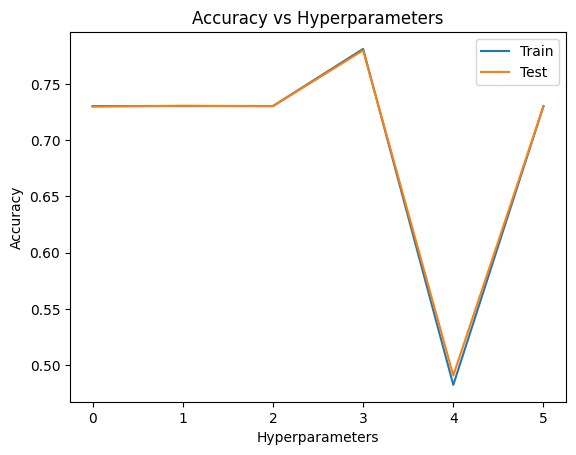

In [188]:
accs = np.zeros((len(part1_Hyp), 2))

for hyp in part1_Hyp:
    print("nfeatures = ", hyp[0], " sigma = ", hyp[1], " c = ", hyp[2])
    extract_sift_features(hyp[0], hyp[1])
    kmeans = cluster_features(100, train_features)
    train_histograms = make_histograms(descriptor_list, kmeans, 100)
    svm = train_SVM(train_histograms, train_labels, hyp[2])
    accs[part1_Hyp.index(hyp), 0] = test_SVM(svm, train_histograms, train_labels, 'Train')

    test_histograms = make_histograms(descriptor_list_test, kmeans, 100)
    accs[part1_Hyp.index(hyp), 1] = test_SVM(svm, test_histograms, test_labels, 'Test')

plt.plot(range(len(part1_Hyp)), accs[:, 0], label='Train')
plt.plot(range(len(part1_Hyp)), accs[:, 1], label='Test')
plt.xlabel('Hyperparameters')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Hyperparameters')
plt.legend()
plt.show()


Part 2: CNNs and Transformers

In [156]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

isSubset = False
num_samples_per_class = 1800

# get the dataset and transform the images to tensors and normalize them
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_train = datasets.MNIST(root='./datasets', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./datasets', train=False, download=True, transform=transform)

def split_dataset(mnist_train, num_samples_per_class=1000):
    # Split the dataset into separate subsets for each class
    class_subsets = [[] for _ in range(10)]
    for i in range(len(mnist_train)):
        image, label = mnist_train[i]
        class_subsets[label].append(i)

    # Take a fixed number of samples from each class subset
    balanced_subset_indices = []
    for class_subset in class_subsets:
        selected_indices = np.random.choice(class_subset, size=num_samples_per_class, replace=False)
        balanced_subset_indices.extend(selected_indices)

    # Create a Subset of the MNIST dataset with the balanced subset indices
    balanced_subset = torch.utils.data.Subset(mnist_train, balanced_subset_indices)
    return balanced_subset

if isSubset:
    mnist_train = split_dataset(mnist_train, num_samples_per_class)

Using device: cuda


In [157]:
# implement LeNet to classify the images from the MNIST dataset
class LeNet(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        
        # feature extraction
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(1, 6, kernel_size=5, padding=2),    # 28x28@1 -> 28x28@6
            torch.nn.ReLU(),                                    # activation function
            torch.nn.MaxPool2d(kernel_size=2),                  # 28x28@6 -> 14x14@6
            torch.nn.Conv2d(6, 16, kernel_size=5),              # 14x14@6 -> 10x10@16
            torch.nn.ReLU(),                                    # activation function
            torch.nn.MaxPool2d(kernel_size=2)                   # 10x10@16 -> 5x5@16
        )

        # classifier
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(16*5*5, 120),                       # 16*5*5 -> 120
            torch.nn.ReLU(),                                    # activation function
            torch.nn.Linear(120, 84),                           # 120 -> 84
            torch.nn.ReLU(),                                    # activation function
            torch.nn.Linear(84, num_classes)                    # 84 -> 10
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        probs = self.classifier(x)
        probs = torch.nn.functional.softmax(probs, dim=-1)
        return probs

class LeNet_Double(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet_Double, self).__init__()
        
        # feature extraction
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(1, 6, kernel_size=5, padding=2),    # 28x28@1 -> 28x28@6
            torch.nn.ReLU(),                                    # activation function
            torch.nn.Conv2d(6, 8, kernel_size=5, padding=2),    # 28x28@6 -> 28x28@8
            torch.nn.ReLU(),                                    # activation function
            torch.nn.MaxPool2d(kernel_size=2),                  # 28x28@8 -> 14x14@8
            torch.nn.Conv2d(8, 12, kernel_size=5, padding=2),   # 14x14@8 -> 14x14@12
            torch.nn.ReLU(),                                    # activation function
            torch.nn.Conv2d(12, 16, kernel_size=5),             # 14x14@12 -> 10x10@16
            torch.nn.ReLU(),                                    # activation function
            torch.nn.MaxPool2d(kernel_size=2)                   # 10x10@16 -> 5x5@16
        )

        # classifier
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(16*5*5, 120),                       # 16*5*5 -> 120
            torch.nn.ReLU(),                                    # activation function
            torch.nn.Linear(120, 84),                           # 120 -> 84
            torch.nn.ReLU(),                                    # activation function
            torch.nn.Linear(84, num_classes)                    # 84 -> 10
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        probs = self.classifier(x)
        probs = torch.nn.functional.softmax(probs, dim=-1)
        return probs

# create the model
model = LeNet().to(device)

# uncomment the following 2 lines to use the double LeNet model
# model_double = LeNet_Double().to(device)
# model = model_double

In [158]:
# 8 different hyperparameter settings
hyp_set = []
hyp_set.append(dict(learning_rate=0.01, batch_size=64, epochs=10, optimizer='adam', random_seed=42))
hyp_set.append(dict(learning_rate=0.01, batch_size=64, epochs=10, optimizer='sgd', random_seed=42))
hyp_set.append(dict(learning_rate=0.01, batch_size=128, epochs=10, optimizer='adam', random_seed=42))
hyp_set.append(dict(learning_rate=0.01, batch_size=128, epochs=10, optimizer='sgd', random_seed=42))
hyp_set.append(dict(learning_rate=0.001, batch_size=64, epochs=10, optimizer='adam', random_seed=42))
hyp_set.append(dict(learning_rate=0.001, batch_size=64, epochs=10, optimizer='sgd', random_seed=42))
hyp_set.append(dict(learning_rate=0.001, batch_size=128, epochs=10, optimizer='adam', random_seed=42))
hyp_set.append(dict(learning_rate=0.001, batch_size=128, epochs=10, optimizer='sgd', random_seed=42))

In [159]:
# Hyperparameters
config = hyp_set[4]

# Initialize a new wandb run
wandb.init(project="cv-assi2", config=config, name='18.0K_samples')

# Config is a variable that holds and saves hyperparameters and inputs
config = wandb.config

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Optimizer
if config.optimizer == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=config.learning_rate)

In [160]:
# Data loaders
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=config.batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=config.batch_size, shuffle=False, num_workers=4)

In [161]:
# Training
for epoch in range(config.epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # forward and backward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        # parameter update
        optimizer.step()
        # loss calculation
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_acc += torch.sum(preds == labels.data)

    # calculate average loss and accuracy
    train_loss = train_loss / len(mnist_train)
    train_acc = train_acc.double() / len(mnist_train)

    # Testing
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        test_acc += torch.sum(preds == labels.data)

    # calculate average loss and accuracy
    test_loss = test_loss / len(mnist_test)
    test_acc = test_acc.double() / len(mnist_test)

    # Log the loss and accuracy values at the end of each epoch
    wandb.log({
        "Epoch": epoch,
        "Train Loss": train_loss,
        "Train Accuracy": train_acc,
        "Test Loss": test_loss,
        "Test Accuracy": test_acc
    })

# Finish the run
wandb.finish()

Epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,▁▇▇▇██████
Test Loss,█▃▂▂▁▁▁▁▁▁
Train Accuracy,▁▆▇███████
Train Loss,█▃▂▁▁▁▁▁▁▁
Epoch,9
Test Accuracy,0.9798
Test Loss,1.48228
Train Accuracy,0.98222
Train Loss,1.47925


In [ ]:
# use a 2-layer transformer model instead of the LeNet model
class TransformerModel(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(TransformerModel, self).__init__()
        self.patch_size = 7
        self.num_patches = (28/self.patch_size)**2
    
    